In [1]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

In [2]:
# Tensorflow가 활용할 GPU가 장착되어 있는지 확인해 봅니다.
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## 데이터 로드, 전처리

In [41]:
setattr(tfds.image_classification.cats_vs_dogs, '_URL',"https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip")

In [42]:
import urllib3
urllib3.disable_warnings()

#tfds.disable_progress_bar()   # 이 주석을 풀면 데이터셋 다운로드과정의 프로그레스바가 나타나지 않습니다.

(ds_train, ds_test), ds_info = tfds.load(
    'cats_vs_dogs',
    split=['train[10000:20000]', 'train[:1000]'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
)

In [43]:
# Tensorflow 데이터셋을 로드하면 꼭 feature 정보를 확인해 보세요. 
print(ds_info.features)

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'image/filename': Text(shape=(), dtype=tf.string),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
})


In [44]:
# 데이터의 개수도 확인해 봅시다. 
print(tf.data.experimental.cardinality(ds_train))
print(tf.data.experimental.cardinality(ds_test))

tf.Tensor(10000, shape=(), dtype=int64)
tf.Tensor(1000, shape=(), dtype=int64)


## Input Normalization

In [38]:
# Q. 이미지의 표현이 0과 1 사이로 들어오도록 직접 정규화 코드를 작성해봅시다.
def normalize_and_resize_img(image, label):
    """Normalizes images: `uint8` -> `float32`."""
    IMG_SIZE = (128, 128) # (32,32)
    image = tf.image.resize(image, IMG_SIZE)
    return tf.cast(image, tf.float32)/255.0, label

In [39]:
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=tf.data.AUTOTUNE
    )
    
    if not is_test:
        ds = ds.cache()
        ds = ds.shuffle(1000)
        ds = ds.batch(batch_size)
    else:
        ds = ds.batch(batch_size)
        ds = ds.cache()
    ds = ds.prefetch(tf.data.AUTOTUNE)
    return ds

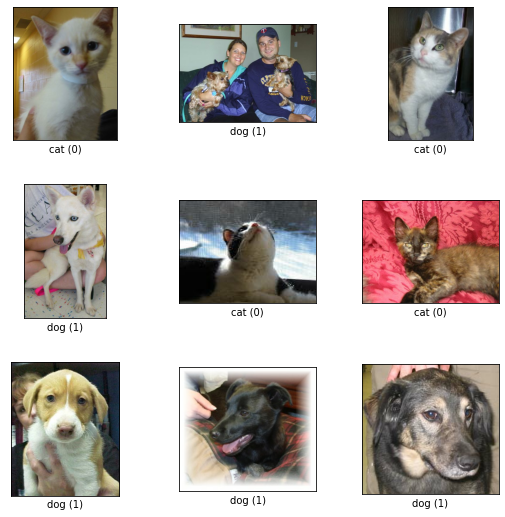

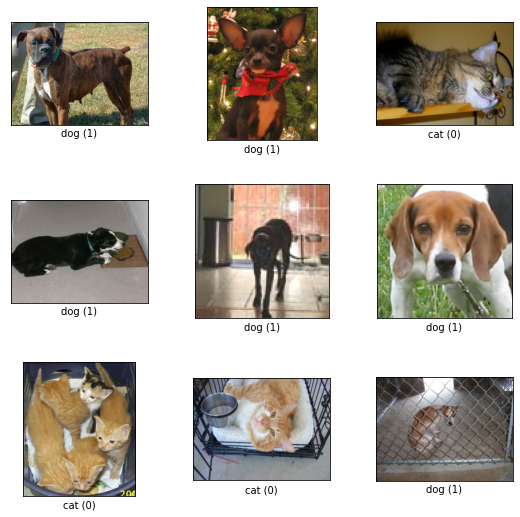

In [9]:
ds_info.features["label"].num_classes
ds_info.features["label"].names
fig = tfds.show_examples(ds_train, ds_info)
fig = tfds.show_examples(ds_test, ds_info)

In [10]:
print(ds_info.features["label"].num_classes)

2


## 모델 만들기

In [11]:
import ResNet

res_34 = ResNet.build_ResNet()
res_34.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 64, 64, 64)   9472        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 64, 64, 64)   256         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 64, 64, 64)   0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [12]:
res_50 = ResNet.build_ResNet(input_shape = (128,128,3), num_block_list = [3,4,6,3], channel_list = [[64,64,256],[128,128,512],[256,256,1024],[512,512,2048]], num_layer = 50 , num_classes = 2)
res_50.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d_36 (Conv2D)              (None, 64, 64, 64)   9472        input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_36 (BatchNo (None, 64, 64, 64)   256         conv2d_36[0][0]                  
__________________________________________________________________________________________________
activation_33 (Activation)      (None, 64, 64, 64)   0           batch_normalization_36[0][0]     
____________________________________________________________________________________________

In [36]:
import PlainModel

plain_34 = PlainModel.build_plain()
plain_34.summary()

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
conv2d_253 (Conv2D)          (None, 64, 64, 64)        9472      
_________________________________________________________________
batch_normalization_253 (Bat (None, 64, 64, 64)        256       
_________________________________________________________________
activation_246 (Activation)  (None, 64, 64, 64)        0         
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 31, 31, 64)        0         
_________________________________________________________________
conv2d_254 (Conv2D)          (None, 31, 31, 64)        36928     
_________________________________________________________________
batch_normalization_254 (Bat (None, 31, 31, 64)        256 

In [37]:
plain_50 = PlainModel.build_plain(input_shape = (128,128,3), num_block_list = [3,4,6,3], channel_list = [[64,64,256],[128,128,512],[256,256,1024],[512,512,2048]], num_layer = 50)
plain_50.summary()

Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
conv2d_286 (Conv2D)          (None, 64, 64, 64)        9472      
_________________________________________________________________
batch_normalization_286 (Bat (None, 64, 64, 64)        256       
_________________________________________________________________
activation_279 (Activation)  (None, 64, 64, 64)        0         
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 31, 31, 64)        0         
_________________________________________________________________
conv2d_287 (Conv2D)          (None, 31, 31, 64)        4160      
_________________________________________________________________
batch_normalization_287 (Bat (None, 31, 31, 64)        256 

## 모델의 시각화

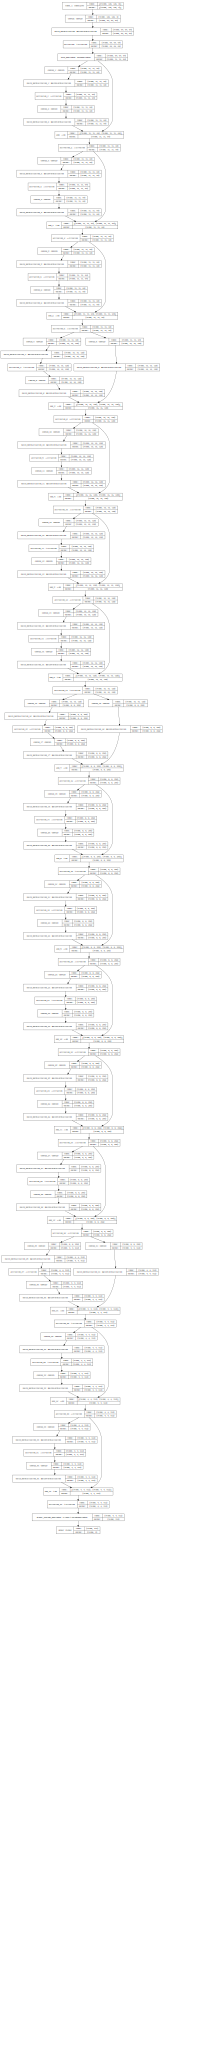

In [15]:
from IPython.display import SVG
from tensorflow.keras.utils import model_to_dot

# Jupyter Notebook에 resnet 34 모델 시각화
SVG(model_to_dot(res_34, show_shapes=True, show_layer_names=True).create(prog='dot', format='svg'))

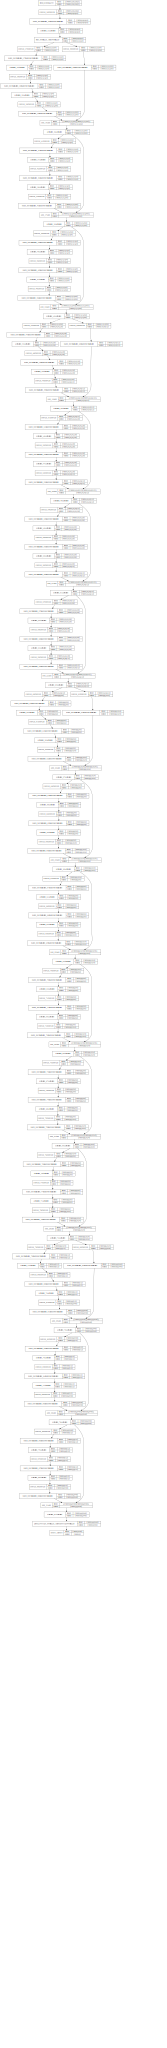

In [16]:
# Jupyter Notebook에 resnet 50모델 시각화
SVG(model_to_dot(res_50, show_shapes=True, show_layer_names=True).create(prog='dot', format='svg'))

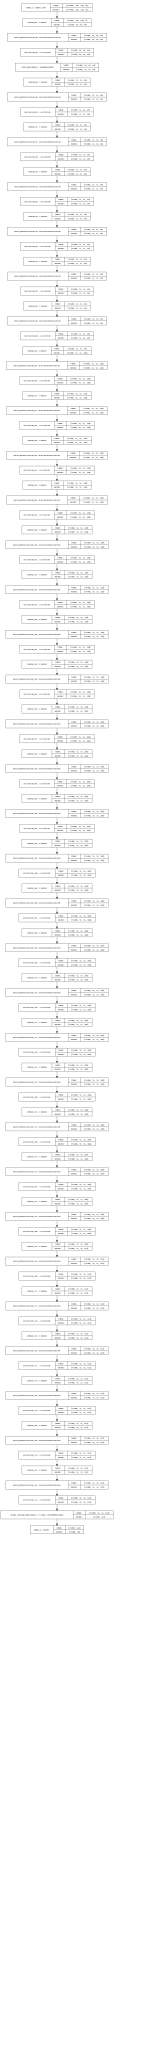

In [17]:
# Jupyter Notebook에 plain34 모델 시각화
SVG(model_to_dot(plain_34, show_shapes=True, show_layer_names=True).create(prog='dot', format='svg'))

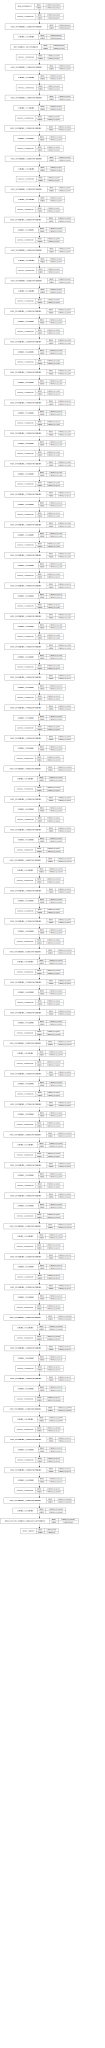

In [18]:
# Jupyter Notebook에 plain50 모델 시각화
SVG(model_to_dot(plain_50, show_shapes=True, show_layer_names=True).create(prog='dot', format='svg'))

## 모델 훈련

In [19]:
BATCH_SIZE = 256
EPOCH = 30

ds_train = apply_normalize_on_dataset(ds_train, batch_size=BATCH_SIZE)
ds_test = apply_normalize_on_dataset(ds_test, batch_size=BATCH_SIZE)

In [22]:
res_34.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01, clipnorm=1.),
    metrics=['accuracy'],
)

history_res34= res_34.fit(
    ds_train,
#     steps_per_epoch=int(ds_info.splits['train[10000:20000]'].num_examples/BATCH_SIZE),
#     validation_steps=int(ds_info.splits['train[:1000]'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
#     verbose=1,
#     use_multiprocessing=True,
)

Epoch 1/30
40/40 [==============================] - 23s 445ms/step - loss: 0.6532 - accuracy: 0.6256 - val_loss: 0.7444 - val_accuracy: 0.4650
Epoch 2/30
40/40 [==============================] - 16s 410ms/step - loss: 0.6127 - accuracy: 0.6649 - val_loss: 0.6930 - val_accuracy: 0.5180
Epoch 3/30
40/40 [==============================] - 16s 404ms/step - loss: 0.5841 - accuracy: 0.6893 - val_loss: 0.7189 - val_accuracy: 0.5350
Epoch 4/30
40/40 [==============================] - 16s 399ms/step - loss: 0.5374 - accuracy: 0.7290 - val_loss: 0.8631 - val_accuracy: 0.5350
Epoch 5/30
40/40 [==============================] - 16s 399ms/step - loss: 0.4825 - accuracy: 0.7689 - val_loss: 1.3706 - val_accuracy: 0.5350
Epoch 6/30
40/40 [==============================] - 16s 401ms/step - loss: 0.4009 - accuracy: 0.8218 - val_loss: 1.6310 - val_accuracy: 0.5350
Epoch 7/30
40/40 [==============================] - 16s 403ms/step - loss: 0.2989 - accuracy: 0.8797 - val_loss: 2.3776 - val_accuracy: 0.5350

In [23]:
res_50.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01, clipnorm=1.),
    metrics=['accuracy'],
)

history_res50= res_50.fit(
    ds_train,
#     steps_per_epoch=int(ds_info.splits['train[10000:20000]'].num_examples/BATCH_SIZE),
#     validation_steps=int(ds_info.splits['train[:1000]'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
#     verbose=1,
#     use_multiprocessing=True,
)

Epoch 1/30
40/40 [==============================] - 48s 897ms/step - loss: 0.7298 - accuracy: 0.5325 - val_loss: 0.6902 - val_accuracy: 0.5350
Epoch 2/30
40/40 [==============================] - 33s 820ms/step - loss: 0.7188 - accuracy: 0.5440 - val_loss: 0.7321 - val_accuracy: 0.5350
Epoch 3/30
40/40 [==============================] - 33s 815ms/step - loss: 0.7126 - accuracy: 0.5610 - val_loss: 0.8270 - val_accuracy: 0.5350
Epoch 4/30
40/40 [==============================] - 33s 823ms/step - loss: 0.7010 - accuracy: 0.5713 - val_loss: 0.8622 - val_accuracy: 0.5350
Epoch 5/30
40/40 [==============================] - 33s 818ms/step - loss: 0.6950 - accuracy: 0.5789 - val_loss: 0.9649 - val_accuracy: 0.5350
Epoch 6/30
40/40 [==============================] - 33s 818ms/step - loss: 0.6850 - accuracy: 0.5853 - val_loss: 0.9039 - val_accuracy: 0.5350
Epoch 7/30
40/40 [==============================] - 33s 821ms/step - loss: 0.6937 - accuracy: 0.5724 - val_loss: 0.8297 - val_accuracy: 0.5350

In [46]:
plain_34.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01, clipnorm=1.),
    metrics=['accuracy'],
)

history_plain34= plain_34.fit(
    ds_train,
#     steps_per_epoch=int(ds_info.splits['train[10000:20000]'].num_examples/BATCH_SIZE),
#     validation_steps=int(ds_info.splits['train[:1000]'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
#     verbose=1,
#     use_multiprocessing=True,
)

/opt/conda/lib/python3.9/site-packages/keras/optimizer_v2/optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Epoch 1/30


ResourceExhaustedError:  OOM when allocating tensor with shape[256,512,31,31] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[node model_6/conv2d_284/Conv2D (defined at tmp/ipykernel_3937/3269101992.py:7) ]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_90902]

Function call stack:
train_function


In [47]:
plain_50.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01, clipnorm=1.),
    metrics=['accuracy'],
)

history_plain50= plain_50.fit(
    ds_train,
#     steps_per_epoch=int(ds_info.splits['train[10000:20000]'].num_examples/BATCH_SIZE),
#     validation_steps=int(ds_info.splits['train[:1000]'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
#     verbose=1,
#     use_multiprocessing=True,
)

Epoch 1/30


ResourceExhaustedError:  OOM when allocating tensor with shape[256,1024,31,31] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[node model_7/conv2d_313/Conv2D (defined at tmp/ipykernel_3937/1951615634.py:7) ]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_102165]

Function call stack:
train_function


## 비교 그래프

In [ ]:
plt.plot(history_plain34.history['loss'], 'r')
plt.plot(history_plain50.history['loss'], 'b')
plt.title('Model training loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['plain_34', 'plain_50'], loc='upper left')
plt.show()

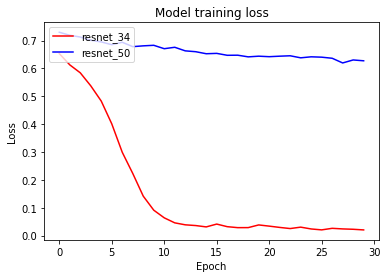

In [28]:
plt.plot(history_res34.history['loss'], 'r')
plt.plot(history_res50.history['loss'], 'b')
plt.title('Model training loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['resnet_34', 'resnet_50'], loc='upper left')
plt.show()

층이 34인 ResNet보다 층이 50인 ResNet이 더 성능이 좋은 것을 알 수 있었다

In [ ]:
plt.plot(history_plain34.history['loss'], 'r')
plt.plot(history_res34.history['loss'], 'b')
plt.title('Model training loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['plain_34', 'resnet_34'], loc='upper left')
plt.show()

In [ ]:
plt.plot(history_plain50.history['loss'], 'r')
plt.plot(history_res50.history['loss'], 'b')
plt.title('Model training loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['plain_50', 'resnet_50'], loc='upper left')
plt.show()

OOM 에러가 떠서 batch size도 작게, resize를 더 작게 했음에도 불구하고 이 문제가 해결되지 않았다...<br>
어떻게 해야 이 에러가 해결될까? ㅜㅜ